In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("OnlineRetail.csv",encoding="ISO-8859-1" )
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


In [4]:
df = df.dropna(subset=['CustomerID']).copy()

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)

In [6]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [7]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [8]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [9]:
customer_df = df.groupby('CustomerID').agg({
    'TotalPrice':'sum',
    'InvoiceNo':'nunique',
    'Quantity':'sum',
    'UnitPrice':'mean'
}).rename(columns={
    'TotalPrice':'TotalSpent',
    'InvoiceNo':'NumInvoices',
    'Quantity':'NumItems',
    'UnitPrice':'AvgPrice'
})

customer_df.head()

,TotalSpent,NumInvoices,NumItems,AvgPrice
CustomerID,,,,
12346.0,77183.60,1,74215,1.040000
12347.0,4310.00,7,2458,2.644011
12348.0,1797.24,4,2341,5.764839
12349.0,1757.55,1,631,8.289041
12350.0,334.40,1,197,3.841176


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_df)

In [11]:
from sklearn.cluster import KMeans

kmeans_lvl1 = KMeans(n_clusters=3, random_state=42)
customer_df['cluster_lvl1'] = kmeans_lvl1.fit_predict(X_scaled)

In [13]:
customer_df['cluster_lvl2'] = -1

for c in customer_df['cluster_lvl1'].unique():
    sub_index = customer_df[customer_df['cluster_lvl1'] == c].index
    n = len(sub_index)
    
    if n >= 2:  # chỉ phân cụm khi đủ mẫu
        kmeans_lvl2 = KMeans(n_clusters=2, random_state=42)
        
        # Sử dụng .iloc để chọn hàng tương ứng
        customer_df.loc[sub_index, 'cluster_lvl2'] = kmeans_lvl2.fit_predict(
            X_scaled[customer_df.index.get_indexer(sub_index)]
        )
    else:
        customer_df.loc[sub_index, 'cluster_lvl2'] = 0

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


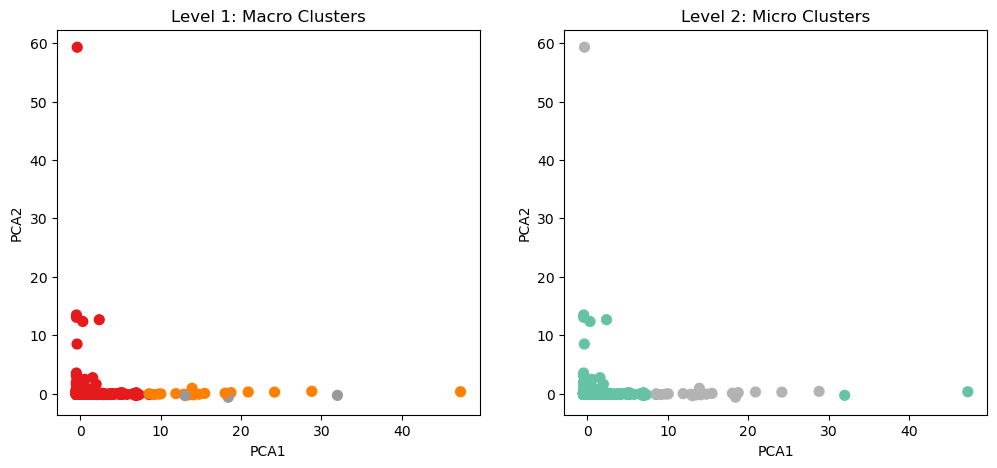

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12,5))

# Level 1
plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=customer_df['cluster_lvl1'], cmap='Set1', s=50)
plt.title("Level 1: Macro Clusters")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# Level 2
plt.subplot(1,2,2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=customer_df['cluster_lvl2'], cmap='Set2', s=50)
plt.title("Level 2: Micro Clusters")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.show()